In [1]:
import nltk
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import contractions

In [2]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('punkt')  # Download punkt tokenizer
nltk.download('wordnet')  # Download WordNet corpus
# Download NLTK stopwords
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger') 

[nltk_data] Downloading package punkt to /home/irteam/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/irteam/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/irteam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/irteam/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
# Load and preprocess the dataset
tr_dataset = pd.read_csv("/home/irteam/minhah-dcloud-dir/minhah/dreaddit/dreaddit-train-aeda.csv")

In [4]:
print(tr_dataset)

              subreddit                                               text  \
0                  ptsd  He said he had not felt that way before, sugge...   
1            assistance  Hey there r/assistance, Not sure if this is th...   
2                  ptsd  My mom then hit me with the newspaper and it s...   
3         relationships  until i met my new boyfriend, he is amazing, h...   
4      survivorsofabuse  October is Domestic Violence Awareness Month a...   
...                 ...                                                ...   
45403              ptsd  I ! : , was talking : . ? , to ! my . ! mom , ...   
45404              ptsd  I ! ; : , ! was talking : . . ? , to ! . my . ...   
45405              ptsd  ! I ! ; , : , , ! was talking : : . . ? , to !...   
45406              ptsd  ! I ! ! ; , : , , ! was talking : . : ! . . : ...   
45407              ptsd  ! I , ! ! ; , : , , ! ? was talking : . : ! ? ...   

       label                       intent  ilabels  
0         

In [5]:
# Split dataset into train, validation, and test sets
train_data, val_data = train_test_split(tr_dataset, test_size=0.2, random_state=42)

In [6]:
from torch.utils.data import Dataset
import numpy as np
import re
import nltk
import string
texts_all=[]
weights_all=[]
class D_Dataset(Dataset):
    def __init__(self, dataframe, tokenizer):
        texts = dataframe.text.values.tolist()

        self.texts = [tokenizer(text, padding='max_length',
                                max_length=512,
                                truncation=True,
                                return_tensors="pt")
                      for text in texts]
        if 'label' in dataframe:
            classes = dataframe.label.values.tolist()
            self.labels = classes
    
    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]

        label = -1
        if hasattr(self, 'labels'):
            label = self.labels[idx]

        return text, label

In [7]:
from torch import nn

class Classifier(nn.Module):
    def __init__(self, base_model):
        super(Classifier, self).__init__()

        self.bert = base_model
        self.fc1 = nn.Linear(768, 32)
        self.fc2 = nn.Linear(32, 1)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, input_ids, attention_mask):
        bert_out = self.bert(input_ids=input_ids,
                             attention_mask=attention_mask)[0][:, 0]
        x = self.fc1(bert_out)
        x = self.relu(x)
        
        x = self.fc2(x)
        x = self.sigmoid(x)

        return x

In [8]:
import torch
from torch.optim import Adam
from tqdm import tqdm

def train(model, train_dataloader, val_dataloader, learning_rate, epochs):
    best_val_loss = float('inf')
    early_stopping_threshold_count = 0
    
    
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:2" if use_cuda else "cpu")

    criterion = nn.BCELoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)
#     if torch.cuda.device_count() > 1:
#         device_ids = [1, 2, 3,4,5,6]  # Specify the desired GPU device IDs
#         print("Using", len(device_ids), "GPUs!")
#         model = nn.DataParallel(model, device_ids=device_ids)

    model = model.to(device)
    criterion = criterion.to(device)
    tr_loss=[]
    tr_acc=[]
    t_loss=[]
    t_acc=[]

    for epoch in range(epochs):
        total_acc_train = 0
        total_loss_train = 0
        
        model.train()
        
        for train_input, train_label in tqdm(train_dataloader):
            attention_mask = train_input['attention_mask'].to(device)
            input_ids = train_input['input_ids'].squeeze(1).to(device)

            train_label = train_label.to(device)

            output = model(input_ids, attention_mask)

            loss = criterion(output, train_label.float().unsqueeze(1))

            total_loss_train += loss.item()

            acc = ((output >= 0.5).int() == train_label.unsqueeze(1)).sum().item()
            total_acc_train += acc

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        with torch.no_grad():
            total_acc_val = 0
            total_loss_val = 0
            
            model.eval()
            
            for val_input, val_label in tqdm(val_dataloader):
                attention_mask = val_input['attention_mask'].to(device)
                input_ids = val_input['input_ids'].squeeze(1).to(device)

                val_label = val_label.to(device)

                output = model(input_ids, attention_mask)

                loss = criterion(output, val_label.float().unsqueeze(1))

                total_loss_val += loss.item()

                acc = ((output >= 0.5).int() == val_label.unsqueeze(1)).sum().item()
                total_acc_val += acc
            
            print(f'Epochs: {epoch + 1} '
                  f'| Train Loss: {total_loss_train / len(train_dataloader): .3f} '
                  f'| Train Accuracy: {total_acc_train / (len(train_dataloader.dataset)): .3f} '
                  f'| Val Loss: {total_loss_val / len(val_dataloader): .3f} '
                  f'| Val Accuracy: {total_acc_val / len(val_dataloader.dataset): .3f}')
            tr_loss.append(total_loss_train / len(train_dataloader))
            tr_acc.append(total_acc_train / (len(train_dataloader.dataset)))
            t_loss.append(total_loss_val / len(val_dataloader))
            t_acc.append(total_acc_val / len(val_dataloader.dataset))
            
            if best_val_loss > total_loss_val:
                best_val_loss = total_loss_val
                torch.save(model, f"roberta_model_dreaddit_best_aeda.pt")
                print("Saved model")
                early_stopping_threshold_count = 0
            else:
                early_stopping_threshold_count += 1
                
            if early_stopping_threshold_count >= 1:
                print("Early stopping")
                break
    return tr_loss, t_loss, tr_acc, t_acc

In [9]:
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import DataLoader

torch.manual_seed(0)
np.random.seed(0)
    
    
BERT_MODEL = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL)
base_model = AutoModel.from_pretrained(BERT_MODEL)

train_dataloader = DataLoader(D_Dataset(train_data, tokenizer), batch_size=8, shuffle=True, num_workers=0)
val_dataloader = DataLoader(D_Dataset(val_data, tokenizer), batch_size=8, num_workers=0)

model = Classifier(base_model)


learning_rate = 1e-6
epochs = 30
train_loss_values, val_loss_values, train_accuracy_values, val_accuracy_values= train(model, train_dataloader, val_dataloader, learning_rate, epochs)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 1136/1136 [01:4

Epochs: 1 | Train Loss:  0.387 | Train Accuracy:  0.823 | Val Loss:  0.244 | Val Accuracy:  0.908


  0%|          | 0/4541 [00:00<?, ?it/s]

Saved model


100%|██████████| 1136/1136 [01:43<00:00, 10.94it/s]


Epochs: 2 | Train Loss:  0.171 | Train Accuracy:  0.944 | Val Loss:  0.107 | Val Accuracy:  0.969


  0%|          | 0/4541 [00:00<?, ?it/s]

Saved model


100%|██████████| 1136/1136 [01:43<00:00, 10.94it/s]


Epochs: 3 | Train Loss:  0.079 | Train Accuracy:  0.978 | Val Loss:  0.052 | Val Accuracy:  0.989


  0%|          | 0/4541 [00:00<?, ?it/s]

Saved model


100%|██████████| 1136/1136 [01:43<00:00, 10.94it/s]


Epochs: 4 | Train Loss:  0.048 | Train Accuracy:  0.988 | Val Loss:  0.031 | Val Accuracy:  0.994


  0%|          | 0/4541 [00:00<?, ?it/s]

Saved model


100%|██████████| 1136/1136 [01:44<00:00, 10.92it/s]


Epochs: 5 | Train Loss:  0.033 | Train Accuracy:  0.992 | Val Loss:  0.023 | Val Accuracy:  0.995


  0%|          | 0/4541 [00:00<?, ?it/s]

Saved model


100%|██████████| 1136/1136 [01:43<00:00, 10.94it/s]


Epochs: 6 | Train Loss:  0.022 | Train Accuracy:  0.994 | Val Loss:  0.019 | Val Accuracy:  0.995


  0%|          | 0/4541 [00:00<?, ?it/s]

Saved model


100%|██████████| 1136/1136 [01:43<00:00, 10.93it/s]


Epochs: 7 | Train Loss:  0.017 | Train Accuracy:  0.996 | Val Loss:  0.013 | Val Accuracy:  0.997


  0%|          | 0/4541 [00:00<?, ?it/s]

Saved model


100%|██████████| 1136/1136 [01:43<00:00, 10.94it/s]


Epochs: 8 | Train Loss:  0.013 | Train Accuracy:  0.997 | Val Loss:  0.012 | Val Accuracy:  0.997


  0%|          | 0/4541 [00:00<?, ?it/s]

Saved model


100%|██████████| 1136/1136 [01:43<00:00, 10.93it/s]


Epochs: 9 | Train Loss:  0.010 | Train Accuracy:  0.997 | Val Loss:  0.009 | Val Accuracy:  0.997


  0%|          | 0/4541 [00:00<?, ?it/s]

Saved model


100%|██████████| 1136/1136 [01:43<00:00, 10.93it/s]

Epochs: 10 | Train Loss:  0.009 | Train Accuracy:  0.997 | Val Loss:  0.012 | Val Accuracy:  0.996
Early stopping


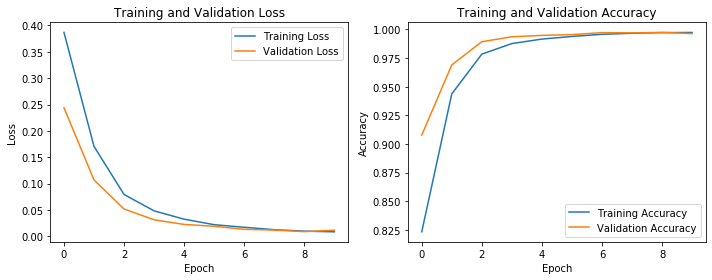

In [10]:
# Plotting learning curves
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy_values, label='Training Accuracy')
plt.plot(val_accuracy_values, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
def get_text_predictions(model, loader):
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:2" if use_cuda else "cpu")
#     if torch.cuda.device_count() > 1:
#         device_ids = [1, 2, 3,4,5,6]  # Specify the desired GPU device IDs
#         print("Using", len(device_ids), "GPUs!")
#         model = nn.DataParallel(model, device_ids=device_ids)

    model = model.to(device)
    
    
    results_predictions = []
    with torch.no_grad():
        model.eval()
        for data_input, _ in tqdm(loader):
            attention_mask = data_input['attention_mask'].to(device)
            input_ids = data_input['input_ids'].squeeze(1).to(device)


            output = model(input_ids, attention_mask)
            
            output = (output > 0.5).int()
            results_predictions.append(output)
    
    return torch.cat(results_predictions).cpu().detach().numpy()

In [12]:
model = torch.load("roberta_model_dreaddit_best_aeda.pt")

In [13]:
# Load and preprocess the dataset
test_df = pd.read_csv("/home/irteam/minhah-dcloud-dir/minhah/dreaddit/dreaddit-test-pp.csv")

In [14]:
print(test_df)

         subreddit                                               text  label  \
0    relationships  Its like that, if you want or not.“ ME: I have...      0   
1          anxiety  I man the front desk and my title is HR Custom...      0   
2             ptsd  We'd be saving so much money with this new hou...      1   
3             ptsd  My ex used to shoot back with "Do you want me ...      1   
4    relationships  I haven’t said anything to him yet because I’m...      0   
..             ...                                                ...    ...   
710           ptsd  i have horrible vivid nightmares every night. ...      1   
711  relationships  Also I can't think about both of them without ...      1   
712  relationships  Furthermore, I told him before we got really s...      1   
713     assistance  Here's the link to my amazon wish list where t...      0   
714     assistance  How can I keep us protected? They have already...      1   

                          intent  ilabe

In [15]:
test_dataloader = DataLoader(D_Dataset(test_df, tokenizer), batch_size=8, shuffle=False, num_workers=0)

In [16]:
sample_submission = pd.read_csv("/home/irteam/minhah-dcloud-dir/minhah/dreaddit/dreaddit-test.csv")

In [17]:
sample_submission["prediction"] = get_text_predictions(model, test_dataloader)

100%|██████████| 90/90 [00:08<00:00, 11.17it/s]


In [18]:
# display(sample_submission.head(20))

In [19]:
sample_submission.head(20)

,id,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment,prediction
0,896,relationships,7nu7as,"[50, 55]","Its like that, if you want or not.“ ME: I have...",0,0.8,1.514981e+09,22,-1.238793,...,1.2000,1.0,1.65864,1.32245,1.80264,0.63,62,-0.148707,0.000000,0
1,19059,anxiety,680i6d,"(5, 10)",I man the front desk and my title is HR Custom...,0,1.0,1.493348e+09,5,7.684583,...,1.1250,1.0,1.69133,1.69180,1.97249,1.00,2,7.398222,-0.065909,0
2,7977,ptsd,8eeu1t,"(5, 10)",We'd be saving so much money with this new hou...,1,1.0,1.524517e+09,10,2.360408,...,1.0000,1.0,1.70974,1.52985,1.86108,1.00,8,3.149288,-0.036818,1
3,1214,ptsd,8d28vu,"[2, 7]","My ex used to shoot back with ""Do you want me ...",1,0.5,1.524018e+09,5,5.997000,...,1.3000,1.0,1.72615,1.52000,1.84909,1.00,7,6.606000,-0.066667,1
4,1965,relationships,7r1e85,"[23, 28]",I haven’t said anything to him yet because I’m...,0,0.8,1.516200e+09,138,4.649418,...,1.1429,1.0,1.75642,1.43582,1.91725,0.84,70,4.801869,0.141667,0
5,850,assistance,7py440,"[10, 15]",Thanks. Edit 1 - Fuel Receipt As Requested. <u...,0,1.0,1.515778e+09,7,0.910714,...,1.0000,1.0,1.70441,1.56364,1.76971,0.70,16,3.289524,-0.275000,0
6,1643,homeless,9e8zyg,"[10, 15]","When moving into their tiny house, they would ...",0,0.0,1.536453e+09,14,15.815576,...,1.0000,1.0,1.59863,1.41860,1.82149,0.82,15,13.097570,0.000000,0
7,39090,anxiety,71ma4y,"(0, 5)","More specifically, for example, I live with ro...",1,0.8,1.506028e+09,6,10.029951,...,1.1429,1.0,1.70439,1.50598,1.82334,0.88,6,9.593832,0.039977,1
8,19468,almosthomeless,6d5p34,"(0, 5)",Long story short my family in NE Ohio is abusi...,1,1.0,1.495666e+09,21,1.068692,...,1.0000,1.0,1.69207,1.62817,1.88011,0.81,30,3.251153,0.082407,1
9,48595,domesticviolence,83d7jt,"(5, 10)","This new ""roommate"" lived 3 hours away in an p...",0,0.6,1.520659e+09,7,5.789629,...,1.0000,1.0,1.70685,1.73571,1.88339,1.00,7,5.975440,0.258965,0


In [20]:
sample_submission.to_csv("/home/irteam/minhah-dcloud-dir/minhah/dreaddit/dreaddit-test-roberta_aeda.csv", index=False)

In [21]:
import pandas as pd
sample_submission = pd.read_csv("/home/irteam/minhah-dcloud-dir/minhah/dreaddit/dreaddit-test-roberta_aeda.csv")

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
# Print classification report
class_names = ['control','Depressed']
classification_rep = classification_report(sample_submission['label'],sample_submission['prediction'], target_names=class_names)
print("Classification Report:")
print(classification_rep)


Classification Report:
              precision    recall  f1-score   support

     control       0.80      0.78      0.79       346
   Depressed       0.80      0.82      0.81       369

    accuracy                           0.80       715
   macro avg       0.80      0.80      0.80       715
weighted avg       0.80      0.80      0.80       715



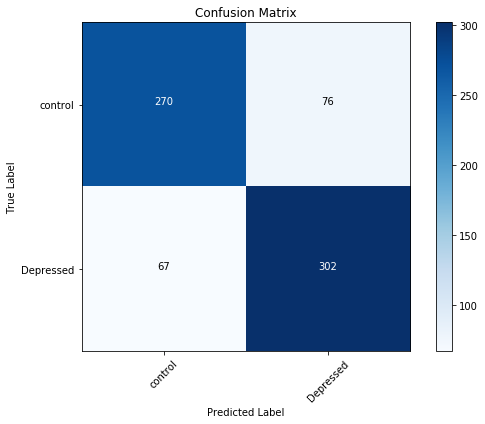

In [23]:
import matplotlib.pyplot as plt
import numpy as np
# Compute confusion matrix
cm = confusion_matrix(sample_submission['label'],sample_submission['prediction'])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Add count values to the plot
thresh = cm.max() / 2.0  # Threshold for color change
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()
